# Our plan of action
![](../images/Conversation%20Q_A%20Prototype.png)

In [1]:
# https://www.philschmid.de/fine-tune-flan-t5
from datasets import load_dataset, Dataset
from random import randrange
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, \
    Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, pipeline

import os
import openai

import pandas as pd
from tqdm import tqdm

In [2]:
dataset_id = "samsum"

# Load dataset from the hub
dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Found cached dataset samsum (/Users/sinanozdemir/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e)


  0%|          | 0/3 [00:00<?, ?it/s]

Train dataset size: 14732
Test dataset size: 819


In [3]:
sample = dataset['train'][randrange(len(dataset["train"]))]
print(f"dialogue: \n{sample['dialogue']}\n---------------")
print(f"summary: \n{sample['summary']}\n---------------")


dialogue: 
Brooke: Hi 🙂
Brooke: Just wanted to let you know that I just finished Coelho.
Sheila: Hi there 🙂
Sheila: Nice. Did you enjoy it?
Brooke: I first read The Pilgrimage and had an idea on how he writes and thinks as an author.
Brooke: But that book you gave me, Eleven Minutes, was so different!
Sheila: He can write about anything, but one thing that stays the same is that it's always gonna be very emotional.
Brooke: I cried while reading both of them. But they moved me in a different way.
Sheila: I didn't read The Pilgrimage, the title alone suggests I wouldn't be interested in that story.
Brooke: If you wish, I can always borrow you this one.
Sheila: I'll keep that in mind.
Sheila: I'm glad you enjoyed Eleven Minutes as much as I did.
Brooke: Are you free tomorrow at 18:00?
Sheila: I might be, why?
Brooke: I will be in your neighbourhood and I can drop by to give it back.
Sheila: You can come, but I gotta leave at 7.
Brooke: Sure, I'll be on time!
Sheila: See you tomorrow at 6 

In [4]:
model_id="google/flan-t5-small"

# Load tokenizer of FLAN-T5
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [5]:
def preprocess_function(sample):
    # add prefix to the input for t5
    inputs = ["summarize: " + item for item in sample["dialogue"]]

    # tokenize inputs
    model_inputs = tokenizer(inputs, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text_target=sample["summary"], truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

dataset['tokenized_train'] = dataset['train'].map(preprocess_function, batched=True, remove_columns=["dialogue", "summary", "id"])
dataset['tokenized_test'] = dataset['test'].map(preprocess_function, batched=True, remove_columns=["dialogue", "summary", "id"])


Loading cached processed dataset at /Users/sinanozdemir/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e/cache-6fd195173404bd74.arrow
Loading cached processed dataset at /Users/sinanozdemir/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e/cache-2a5c805eca4875ec.arrow


In [6]:
sample = dataset['tokenized_train'][randrange(len(dataset["tokenized_train"]))]
print(f"input_ids: \n{sample['input_ids']}\n---------------")
print(f"labels: \n{sample['labels']}\n---------------")


input_ids: 
[21603, 10, 29298, 10, 1521, 15480, 11, 239, 234, 58, 10445, 10, 150, 855, 29298, 10, 2049, 10445, 10, 18364, 541, 58, 1]
---------------
labels: 
[29298, 31, 7, 1362, 33, 29, 31, 17, 234, 5, 3, 1]
---------------


In [7]:

# huggingface hub model id
model_id="google/flan-t5-small"

# load model from the hub
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)


In [8]:

# we want to ignore tokenizer pad token in the loss
# label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=tokenizer.pad_token_id
)

In [9]:

# Hugging Face repository id
repository_id = f"{model_id.split('/')[1]}-{dataset_id}"

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    predict_with_generate=False,
    fp16=False, # Overflows with fp16
    learning_rate=5e-5,
    num_train_epochs=1,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="steps",
    logging_steps=1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["tokenized_train"],
    eval_dataset=dataset["tokenized_test"],
    data_collator=data_collator
)


In [11]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 819
  Batch size = 32
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 31.901212692260742,
 'eval_runtime': 53.1241,
 'eval_samples_per_second': 15.417,
 'eval_steps_per_second': 0.489}

In [ ]:
# trainer.train()  # not running because someone else already did

In [ ]:
trainer.evaluate()

In [10]:
# select a random test sample
sample = dataset['test'][randrange(len(dataset["test"]))]
print(f"dialogue: \n{sample['dialogue']}\n---------------")


dialogue: 
Richie: Pogba
Clay: Pogboom
Richie: what a s strike yoh!
Clay: was off the seat the moment he chopped the ball back to his right foot
Richie: me too dude
Clay: hope his form lasts
Richie: This season he's more mature
Clay: Yeah, Jose has his trust in him
Richie: everyone does
Clay: yeah, he really deserved to score after his first 60 minutes
Richie: reward
Clay: yeah man
Richie: cool then 
Clay: cool
---------------


In [11]:
# base_model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained("philschmid/flan-t5-base-samsum")

loading configuration file config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--philschmid--flan-t5-base-samsum/snapshots/dab5b3234360d786065ab29c6dd5af00a0bff05f/config.json
Model config T5Config {
  "_name_or_path": "philschmid/flan-t5-base-samsum",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_len

In [35]:
# summarize dialogue
summary = tokenizer.batch_decode(
    base_model.generate(**tokenizer.encode_plus(f'summarize: {sample["dialogue"]}', 
                                                     return_tensors='pt'), 
                             num_beams=4,
                             min_length=30, max_length=200
                            ), skip_special_tokens=True
)
print(f"base flan-t5 summary:\n{summary}")


base flan-t5 summary:
["Mickey, Jessica and Ollie are talking about a sculpture garden in Finnland. It's a sculpture garden in Finnland."]


In [36]:
# summarize dialogue
summary = tokenizer.batch_decode(
    model.generate(**tokenizer.encode_plus(f'summarize: {sample["dialogue"]}', 
                                                     return_tensors='pt'), 
                             num_beams=4,
                             min_length=30, max_length=200
                            ), skip_special_tokens=True
)
print(f"fine-tuned flan-t5 summary:\n{summary}")


fine-tuned flan-t5 summary:
["Kelly's place is in a sculpture garden in Finnland. There are a hundred of human-sized figures in the garden. Ollie and Mickey are going to Nagoro village in Japan."]


In [14]:
# load model and tokenizer from huggingface hub with pipeline
summarizer = pipeline("summarization", model="philschmid/flan-t5-base-samsum")


In [48]:
# select a random test sample
sample = dataset['test'][randrange(len(dataset["test"]))]
print(f"dialogue: \n{sample['dialogue']}\n---------------")

# summarize dialogue
res = summarizer(sample["dialogue"])

print(f"flan-t5 summary:\n{res[0]['summary_text']}")


Your max_length is set to 200, but you input_length is only 131. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


dialogue: 
Harry: heyyyy are you there??
Cindy: Yes dear what is it?
Harry: Can you call Ela and tell her i need to talk urgent please pick my call.
Cindy: what happened now? an other fight :O
Harry: please tell her
Cindy: MAN! you guys... am i some kind of a messenger service here?
Harry: PLEASEEEEEEEEE ?
Cindy: ok doing.... but thats the last time.
Harry: Yes like always:P
Cindy: Hate you seriously man.
Harry: Thank you
Cindy: Done you can call her now.
---------------
flan-t5 summary:
Harry wants Cindy to call Ela and tell her he needs to talk urgently. Cindy is a messenger service at Harry's place.


In [17]:
answers = [_ for _ in res[0]['summary_text'].split('. ') if len(_) > 2]

answers

['Joy sends Peter a link to her beauty shop',
 'Peter will look at it',
 'Joy will let him know if he should ask any questions.']

In [111]:
openai.api_key = os.getenv("OPENAI_API_KEY")

def convert_a_to_q(answers, model='text-davinci-003'):
    response = openai.Completion.create(
      model=model,
      prompt=f"convert these answers into questions:\n" + '\n'.join([f'{index+1}. {answer}' for index, answer in enumerate(answers)]),
      temperature=0.2,
      max_tokens=256,
      top_p=0.1
    )
#     print(response.choices[0].text.strip())
    return list(zip([x[3:] if '. ' in x else x for x in (response.choices[0].text.strip()).split('\n')], answers))


In [112]:
convert_a_to_q(answers)

[('Justin has seen the last episode of Game of Thrones.',
  'The weather in Poland is getting cooler'),
 ("Justin can't wait to see it.",
  "Justin hasn't seen the last episode of Game of Thrones yet"),
 ('Justin has seen the last episode of Game of Thrones.',
  "Justin can't wait to see it.")]

In [49]:
conv_data = [] 
NUM_TO_USE = 100

for dialogue in tqdm(dataset['train'][:NUM_TO_USE]['dialogue']):
    res = summarizer(dialogue)
    answers = [_ for _ in res[0]['summary_text'].split('. ') if len(_) > 2]
    random_dialogue = dataset['test'][randrange(len(dataset['test']))]['dialogue']
    for question, answer in convert_a_to_q(answers):
        if len(question) >= 20:
            conv_data.append({'question': question, 'prompt': question + ': ' + dialogue, 'answer': answer})

            # pair questions with irrelevant conv to generate: "This transcript does not say."
            conv_data.append({'question': question, 'prompt': question + ': ' + random_dialogue, 'answer': 'I cannot be sure given this transcript'})


 98%|███████████████████████████████████████▏| 98/100 [09:07<00:11,  5.63s/it]Your max_length is set to 200, but you input_length is only 84. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


100%|███████████████████████████████████████| 100/100 [09:17<00:00,  5.57s/it]


In [50]:
conv_df = pd.DataFrame(conv_data)

conv_df

,question,prompt,answer
0,Did Amanda bake cookies for Jerry?,Did Amanda bake cookies for Jerry?: Amanda: I ...,Amanda baked cookies for Jerry
1,Did Amanda bake cookies for Jerry?,Did Amanda bake cookies for Jerry?: Val: it's ...,I cannot be sure given this transcript
2,When will she bring them?,When will she bring them?: Amanda: I baked co...,She will bring them tomorrow
3,When will she bring them?,When will she bring them?: Val: it's raining!\...,I cannot be sure given this transcript
4,Will Amanda bring Jerry some cookies?,Will Amanda bring Jerry some cookies?: Amanda:...,Amanda will bring Jerry some cookies
...,...,...,...
557,Is the weather in Poland getting cooler?,Is the weather in Poland getting cooler?: Adel...,I cannot be sure given this transcript
558,Has Justin seen the last episode of Game of Th...,Has Justin seen the last episode of Game of Th...,Justin hasn't seen the last episode of Game of...
559,Has Justin seen the last episode of Game of Th...,Has Justin seen the last episode of Game of Th...,I cannot be sure given this transcript
560,Why can't Justin wait to see it?,Why can't Justin wait to see it?: Tom: How’s t...,Justin can't wait to see it.


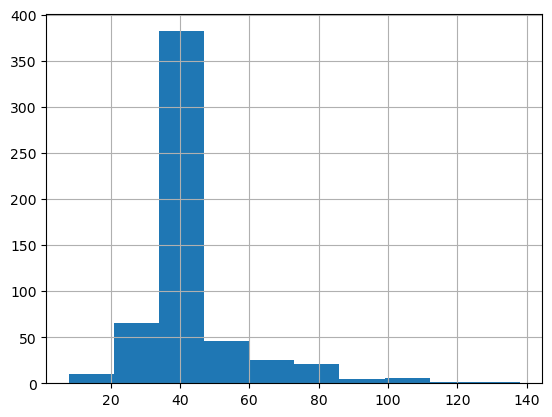

In [51]:
conv_df['answer'].str.len().hist()

In [52]:
conv_df = conv_df[conv_df['question'].str.len() >= 20]
conv_df = conv_df[conv_df['answer'].str.len() >= 20]

conv_df.shape

(554, 3)

In [235]:
conv_df.to_csv('../data/conversation_qa.csv', index=False)

In [236]:
conv_df = pd.read_csv('../data/conversation_qa.csv')

In [173]:
conv_qa_dataset = Dataset.from_pandas(conv_df)

conv_qa_dataset = conv_qa_dataset.train_test_split()

In [174]:
conv_qa_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'prompt', 'answer'],
        num_rows: 415
    })
    test: Dataset({
        features: ['question', 'prompt', 'answer'],
        num_rows: 139
    })
})

In [175]:
def preprocess_function(sample):
    # add prefix to the input for t5

    # tokenize inputs
    model_inputs = tokenizer(sample["prompt"], truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text_target=sample["answer"], truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

conv_qa_dataset['tokenized_train'] = conv_qa_dataset['train'].map(preprocess_function, batched=True, remove_columns=["question", "prompt", "answer"])
conv_qa_dataset['tokenized_test'] = conv_qa_dataset['test'].map(preprocess_function, batched=True, remove_columns=["question", "prompt", "answer"])


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [176]:
conv_qa_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'prompt', 'answer'],
        num_rows: 415
    })
    test: Dataset({
        features: ['question', 'prompt', 'answer'],
        num_rows: 139
    })
    tokenized_train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 415
    })
    tokenized_test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 139
    })
})

In [41]:
# model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("philschmid/flan-t5-base-samsum")

loading configuration file config.json from cache at /Users/sinanozdemir/.cache/huggingface/hub/models--philschmid--flan-t5-base-samsum/snapshots/dab5b3234360d786065ab29c6dd5af00a0bff05f/config.json
Model config T5Config {
  "_name_or_path": "philschmid/flan-t5-base-samsum",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_len

In [44]:
task = 'conv_qa'
repository_id = f"{model_id.split('/')[1]}-{dataset_id}-{task}"

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    predict_with_generate=False,
    fp16=False, # Overflows with fp16
    learning_rate=5e-5,
    num_train_epochs=10,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="steps",
    logging_steps=1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=conv_qa_dataset["tokenized_train"],
    eval_dataset=conv_qa_dataset["tokenized_test"],
    data_collator=data_collator
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [45]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 139
  Batch size = 32


{'eval_loss': 31.164133071899414,
 'eval_runtime': 24.0401,
 'eval_samples_per_second': 5.782,
 'eval_steps_per_second': 0.208}

In [46]:
trainer.train()

/opt/homebrew/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 415
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 260


Epoch,Training Loss,Validation Loss
1,6.808400,6.813702
2,2.010200,2.525110
3,1.899400,1.351636
4,0.880100,0.532311
5,0.605100,0.236293
6,0.402500,0.154330
7,0.212400,0.122804
8,0.202300,0.114072
9,0.217500,0.108529
10,0.169300,0.105540


***** Running Evaluation *****
  Num examples = 139
  Batch size = 32
Saving model checkpoint to flan-t5-small-samsum-conv_qa/checkpoint-26
Configuration saved in flan-t5-small-samsum-conv_qa/checkpoint-26/config.json
Model weights saved in flan-t5-small-samsum-conv_qa/checkpoint-26/pytorch_model.bin
Deleting older checkpoint [flan-t5-small-samsum-conv_qa/checkpoint-104] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 139
  Batch size = 32
Saving model checkpoint to flan-t5-small-samsum-conv_qa/checkpoint-52
Configuration saved in flan-t5-small-samsum-conv_qa/checkpoint-52/config.json
Model weights saved in flan-t5-small-samsum-conv_qa/checkpoint-52/pytorch_model.bin
Deleting older checkpoint [flan-t5-small-samsum-conv_qa/checkpoint-130] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 139
  Batch size = 32
Saving model checkpoint to flan-t5-small-samsum-conv_qa/checkpoint-78
Configuration saved in flan-t5-small-samsum-conv_qa/ch

TrainOutput(global_step=260, training_loss=2.5851049108574022, metrics={'train_runtime': 5594.4917, 'train_samples_per_second': 0.742, 'train_steps_per_second': 0.046, 'total_flos': 2254570270018560.0, 'train_loss': 2.5851049108574022, 'epoch': 10.0})

In [47]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 139
  Batch size = 32


{'eval_loss': 0.10554023087024689,
 'eval_runtime': 22.4092,
 'eval_samples_per_second': 6.203,
 'eval_steps_per_second': 0.223,
 'epoch': 10.0}

In [48]:
trainer.save_model()

Saving model checkpoint to flan-t5-small-samsum-conv_qa
Configuration saved in flan-t5-small-samsum-conv_qa/config.json
Model weights saved in flan-t5-small-samsum-conv_qa/pytorch_model.bin


In [213]:
# Load the model later

finetuned_qa_model = AutoModelForSeq2SeqLM.from_pretrained(repository_id)

loading configuration file flan-t5-small-samsum-conv_qa/config.json
Model config T5Config {
  "_name_or_path": "flan-t5-small-samsum-conv_qa",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "t

In [228]:
sample = conv_qa_dataset['test'][randrange(len(conv_qa_dataset["test"]))]
print(f"dialogue: \n{sample['prompt']}\n---------------")
question = sample['prompt'].split(': ')[0]
print(f"question: \n{question}\n---------------")
print(f"actual answer: \n{sample['answer']}\n---------------")

dialogue: 
Why isn't Monica interested in buying a day spa gift card for Sophia?: Sophia: What should I get them?
Monica: How should I know?
Sophia: come on help me out
Monica: I dont know really Im bad at buying gifts
Sophia: maybe some day spa gift card
Monica: maybe
Sophia: youre not really helpful :P
Monica: Told ya... bad at gifts
---------------
question: 
Why isn't Monica interested in buying a day spa gift card for Sophia?
---------------
actual answer: 
Sophia wants to buy a day spa gift card, but Monica isn't interested in it
---------------


In [229]:
_in = tokenizer.encode_plus(sample['prompt'], return_tensors='pt')

summary = tokenizer.batch_decode(
    finetuned_qa_model.generate(**_in, 
                                num_beams=3,
                                top_p=0.5,
                                top_k=3,
                                do_sample=True, 
                                early_stopping=True,
                                num_return_sequences=5
                               ), 
    skip_special_tokens=True
)
print("fine-tuned flan-t5 answer:\n" + '\n'.join(summary))


fine-tuned flan-t5 answer:
Monica isn't interested in buying a day spa gift card for Sophia.
Monica isn't interested in buying a day spa gift card for Sophia.
Monica isn't interested in buying a day spa gift card for Sophia.
Monica isn't interested in buying a day spa gift card for Sophia.
Monica isn't interested in buying a day spa gift card for Sophia.


In [230]:
_in['labels'] = tokenizer.encode(sample['answer'], return_tensors='pt')

response = finetuned_qa_model(**_in)

response.loss

tensor(0.9001, grad_fn=<NllLossBackward0>)

In [231]:
call_response = tokenizer.batch_decode(response.logits.argmax(2), skip_special_tokens=True)[0]
print(call_response)


Monica is to buy a day spa gift card for but Monica isn't interested in buying.


In [232]:
from sentence_transformers import SentenceTransformer, util

nli_model = SentenceTransformer('msmarco-distilbert-base-v4')


loading configuration file /Users/sinanozdemir/.cache/torch/sentence_transformers/sentence-transformers_msmarco-distilbert-base-v4/config.json
Model config DistilBertConfig {
  "_name_or_path": "/Users/sinanozdemir/.cache/torch/sentence_transformers/sentence-transformers_msmarco-distilbert-base-v4/",
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.23.1",
  "vocab_size": 30522
}

loading weights file /Users/sinanozdemir/.cache/torch/sentence_transformers/sentence-transformers_msmarco-distilbert-base-v4/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertModel.

All the w

In [233]:

# Single list of sentences
sentences = [sample['prompt'].replace(f'{question}: ', '')] + summary

#Compute embeddings
embeddings = nli_model.encode(sentences, convert_to_tensor=True)

#Compute cosine-similarities for each sentence with each other sentence
cosine_scores = util.cos_sim(embeddings, embeddings)

#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

#Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

for pair in pairs[0:10]:
    i, j = pair['index']
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences[i][:20], sentences[j][:50], pair['score']))

Sophia: What should  		 Monica isn't interested in buying a day spa gift c 		 Score: 0.5544
Sophia: What should  		 Monica isn't interested in buying a day spa gift c 		 Score: 0.5544
Sophia: What should  		 Monica isn't interested in buying a day spa gift c 		 Score: 0.5544
Sophia: What should  		 Monica isn't interested in buying a day spa gift c 		 Score: 0.5544
Sophia: What should  		 Monica isn't interested in buying a day spa gift c 		 Score: 0.5544


In [190]:
from datasets import load_dataset

from random import seed, shuffle
from sentence_transformers import InputExample, losses, evaluation
from torch.utils.data import DataLoader

In [198]:
record

{'question': "Who did Richard take Hannah's parking spot from?",
 'prompt': "Who did Richard take Hannah's parking spot from?: Mariana: Hi, just a quick question. Do you know if the readings for the next session of Stephen’s seminar are in the print shop?\r\nRita: No idea, sorry\r\nChae-yeong: The only thing I know is that they were not yet there on Monday\r\nArthur: Yer, I’ve made the mistake of going on Monday as well and I can confirm the texts were not there and the staff was as rude as always\r\nMariana: Sounds familiar\r\nRita: I’ll go tomorrow morning and let you know if the texts are available\r\nRita: I can’t buy the copies for you because they never have enough at hand but I’ll just ask them to print more for later\r\nChae-yeong: No worries\r\nArthur: Yeah, just let us know if they’re ready, that’s a huge favour already\r\nRita: Cool. Will do! xx",
 'answer': 'I cannot be sure given this transcript'}

In [201]:
train_examples = []

for i, record in enumerate(conv_qa_dataset['train']):
    try:
        answer = record['answer'] if 'I cannot' not in record['answer'] else conv_df[conv_df['prompt'].str.contains(record["question"])][~conv_df['answer'].str.contains('I cannot')].iloc[0].answer
    except:
        continue
    if 'I cannot' in answer:
        continue
    train_examples.append(
        InputExample(
            texts=(
                answer, 
                record['prompt'].replace(record['question']+': ', '')
            ), 
            label=float('I cannot be sure' not in record['answer'])
    )
    )
train_examples[0].__dict__

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_32392/2355648357.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  answer = record['answer'] if 'I cannot' not in record['answer'] else conv_df[conv_df['prompt'].str.contains(record["question"])][~conv_df['answer'].str.contains('I cannot')].iloc[0].answer


{'guid': '',
 'texts': ('Tomorrow he will send George the tracking number of the goods he has shipped to him',
  'Mark: I just shipped the goods\r\nMark: Tomorrow I’ll send you the tracking number\r\nGeorge: Thanks!'),
 'label': 1.0}

In [202]:
test_examples = []

for i, record in enumerate(conv_qa_dataset['test']):
    try:
        answer = record['answer'] if 'I cannot' not in record['answer'] else conv_df[conv_df['prompt'].str.contains(record["question"])][~conv_df['answer'].str.contains('I cannot')].iloc[0].answer
    except:
        continue
    if 'I cannot' in answer:
        continue
    test_examples.append(
        InputExample(
            texts=(
                answer, 
                record['prompt'].replace(record['question']+': ', '')
            ), 
            label=float('I cannot be sure' not in record['answer'])
    )
    )
test_examples[0].__dict__

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_32392/1361839398.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  answer = record['answer'] if 'I cannot' not in record['answer'] else conv_df[conv_df['prompt'].str.contains(record["question"])][~conv_df['answer'].str.contains('I cannot')].iloc[0].answer


{'guid': '',
 'texts': ("Lawrence and Julius are offended by Manutd's performance this season",
  'Julius: dude, your assessment of manutd\r\nLawrence: i have nothing to say, im so offended and hopeless of them this season\r\nJulius: me too\r\nLawrence: i dont even know whats wrong with the team\r\nJulius: the quality is there but nothing is happening\r\nLawrence: the players look tired of something\r\nJulius:  with mourinhos conservative football!!\r\nLawrence: its so boring\r\nJulius: so lifeless\r\nLawrence: man!!\r\nJulius: it needs to change, hope the board sees it\r\nLawrence: sooner than later\r\nJulius: yeah\r\nLawrence: yeah'),
 'label': 1.0}

In [203]:
len(train_examples)

408

In [204]:
from sentence_transformers import SentenceTransformer

nli_model = SentenceTransformer('msmarco-distilbert-base-v4')


# Evaluation data, sentences1 and sentences2 are lists of questions and context respectively and scores are 0 or 1
sentences1, sentences2, scores = [_.texts[0] for _ in train_examples], [_.texts[1] for _ in train_examples], [_.label for _ in train_examples]

# evaluator will evaluate embedding closeness
evaluator = evaluation.EmbeddingSimilarityEvaluator(sentences1, sentences2, scores)

nli_model.evaluate(evaluator)  # initial evalaution (higher embedding similarity is better)


loading configuration file /Users/sinanozdemir/.cache/torch/sentence_transformers/sentence-transformers_msmarco-distilbert-base-v4/config.json
Model config DistilBertConfig {
  "_name_or_path": "/Users/sinanozdemir/.cache/torch/sentence_transformers/sentence-transformers_msmarco-distilbert-base-v4/",
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.23.1",
  "vocab_size": 30522
}

loading weights file /Users/sinanozdemir/.cache/torch/sentence_transformers/sentence-transformers_msmarco-distilbert-base-v4/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertModel.

All the w

0.8189468014796153

In [208]:
# Define the train dataset, a dataloader and the train loss
# A data loader is the object that specifically shuffles/grabs batches of data from a Dataset
# We don't usually have to explicitly create one using the Trainer because it has a default loader built in
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)

train_loss = losses.CosineSimilarityLoss(nli_model)

# Fine-tune the model using the fit method
nli_model.fit(
    train_objectives=[(train_dataloader, train_loss)], 
    output_path='conv_answer_similarity/results',
    epochs=10,
    evaluator=evaluator
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Configuration saved in conv_answer_similarity/results/config.json
Model weights saved in conv_answer_similarity/results/pytorch_model.bin
tokenizer config file saved in conv_answer_similarity/results/tokenizer_config.json
Special tokens file saved in conv_answer_similarity/results/special_tokens_map.json


Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Configuration saved in conv_answer_similarity/results/config.json
Model weights saved in conv_answer_similarity/results/pytorch_model.bin
tokenizer config file saved in conv_answer_similarity/results/tokenizer_config.json
Special tokens file saved in conv_answer_similarity/results/special_tokens_map.json


Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Configuration saved in conv_answer_similarity/results/config.json
Model weights saved in conv_answer_similarity/results/pytorch_model.bin
tokenizer config file saved in conv_answer_similarity/results/tokenizer_config.json
Special tokens file saved in conv_answer_similarity/results/special_tokens_map.json


Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Configuration saved in conv_answer_similarity/results/config.json
Model weights saved in conv_answer_similarity/results/pytorch_model.bin
tokenizer config file saved in conv_answer_similarity/results/tokenizer_config.json
Special tokens file saved in conv_answer_similarity/results/special_tokens_map.json


Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Configuration saved in conv_answer_similarity/results/config.json
Model weights saved in conv_answer_similarity/results/pytorch_model.bin
tokenizer config file saved in conv_answer_similarity/results/tokenizer_config.json
Special tokens file saved in conv_answer_similarity/results/special_tokens_map.json


Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Configuration saved in conv_answer_similarity/results/config.json
Model weights saved in conv_answer_similarity/results/pytorch_model.bin
tokenizer config file saved in conv_answer_similarity/results/tokenizer_config.json
Special tokens file saved in conv_answer_similarity/results/special_tokens_map.json


Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Configuration saved in conv_answer_similarity/results/config.json
Model weights saved in conv_answer_similarity/results/pytorch_model.bin
tokenizer config file saved in conv_answer_similarity/results/tokenizer_config.json
Special tokens file saved in conv_answer_similarity/results/special_tokens_map.json


Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Configuration saved in conv_answer_similarity/results/config.json
Model weights saved in conv_answer_similarity/results/pytorch_model.bin
tokenizer config file saved in conv_answer_similarity/results/tokenizer_config.json
Special tokens file saved in conv_answer_similarity/results/special_tokens_map.json


Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Configuration saved in conv_answer_similarity/results/config.json
Model weights saved in conv_answer_similarity/results/pytorch_model.bin
tokenizer config file saved in conv_answer_similarity/results/tokenizer_config.json
Special tokens file saved in conv_answer_similarity/results/special_tokens_map.json


Iteration:   0%|          | 0/13 [00:00<?, ?it/s]

Configuration saved in conv_answer_similarity/results/config.json
Model weights saved in conv_answer_similarity/results/pytorch_model.bin
tokenizer config file saved in conv_answer_similarity/results/tokenizer_config.json
Special tokens file saved in conv_answer_similarity/results/special_tokens_map.json


In [209]:
nli_model.evaluate(evaluator)  # second evalaution


0.8284796036724091

In [234]:
# load fine-tuned IR model
finetuned_bi_encoder = SentenceTransformer('conv_answer_similarity/results')

#Compute embeddings
embeddings = finetuned_bi_encoder.encode(sentences, convert_to_tensor=True)

#Compute cosine-similarities for each sentence with each other sentence
cosine_scores = util.cos_sim(embeddings, embeddings)

#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

#Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

for pair in pairs[0:10]:
    i, j = pair['index']
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences[i][:20], sentences[j][:50], pair['score']))

loading configuration file conv_answer_similarity/results/config.json
Model config DistilBertConfig {
  "_name_or_path": "conv_answer_similarity/results/",
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.23.1",
  "vocab_size": 30522
}

loading weights file conv_answer_similarity/results/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertModel.

All the weights of DistilBertModel were initialized from the model checkpoint at conv_answer_similarity/results/.
If your task is similar to the task the model of the checkpoint was trained on, you ca

Sophia: What should  		 Monica isn't interested in buying a day spa gift c 		 Score: 0.6484
Sophia: What should  		 Monica isn't interested in buying a day spa gift c 		 Score: 0.6484
Sophia: What should  		 Monica isn't interested in buying a day spa gift c 		 Score: 0.6484
Sophia: What should  		 Monica isn't interested in buying a day spa gift c 		 Score: 0.6484
Sophia: What should  		 Monica isn't interested in buying a day spa gift c 		 Score: 0.6484
